In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold

# visualization
import matplotlib.pyplot as plt

# torch
import torch

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Image Path Setting

In [2]:
IMAGE_ROOT = "/data/ephemeral/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/data/train/outputs_json"

## Load Dataset

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

## ValidationSet에 대한 예측 결과 불러오기

In [4]:
df = pd.read_csv('/data/ephemeral/hbis/logs/base.csv')

In [5]:
len(df.iloc[0]['rle'])

1571

In [6]:
df.head()

,image_name,class,rle
0,image1661130828152,finger-1,1456602 10 1458648 15 1460694 20 1462741 23 14...
1,image1661130828152,finger-2,1696305 6 1698350 15 1700395 23 1702442 26 170...
2,image1661130828152,finger-3,2083503 5 2085547 12 2087593 16 2089640 19 209...
3,image1661130828152,finger-4,471786 8 473831 15 475877 19 477923 23 479970 ...
4,image1661130828152,finger-5,684810 7 686853 14 688897 19 690941 24 692985 ...


In [7]:
df = df[~df['image_name'].isin(['image1661130828152', 'image1661130891365'])]

In [8]:
list(pngs)[1].split("/")[1]

image_dict = {name.split("/")[1]:name for name in list(pngs)}
label_dict = {name.split("/")[1][:-4]+'png':name for name in list(jsons)}

df["image_path"] = df['image_name'].apply(lambda x: image_dict[x])
df["label_path"] = df['image_name'].apply(lambda x: label_dict[x])

In [9]:
image_dict['image1661130828152_R.png']

'ID001/image1661130828152_R.png'

In [10]:
print(image_dict['image1661130828152_R.png'])

ID001/image1661130828152_R.png


## Decoding method (rle to mask)

In [11]:
def rle_to_mask(rle, height, width):
    mask = np.zeros(height * width, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2] - 1
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape((height, width))

In [12]:
def mask_to_poly_seg(mask):
    points = np.argwhere(mask == 1)
    points = points[:, [1, 0]]  # (row, col) => (x, y)
    return points.tolist()

In [13]:
df.head()

,image_name,class,rle,image_path,label_path
58,image1661144691792.png,finger-1,1841712 12 1843757 18 1845803 22 1847850 25 18...,ID004/image1661144691792.png,ID004/image1661144691792.json
59,image1661144691792.png,finger-2,2077319 9 2079363 16 2081408 21 2083455 24 208...,ID004/image1661144691792.png,ID004/image1661144691792.json
60,image1661144691792.png,finger-3,2460359 5 2462401 14 2464445 20 2466491 26 246...,ID004/image1661144691792.png,ID004/image1661144691792.json
61,image1661144691792.png,finger-4,942936 7 944981 13 947027 16 949073 19 951120 ...,ID004/image1661144691792.png,ID004/image1661144691792.json
62,image1661144691792.png,finger-5,1174389 2 1176433 7 1178476 13 1180519 19 1182...,ID004/image1661144691792.png,ID004/image1661144691792.json


## Validation Dataset에 대해 클래스 별 over & under pixels 계산

In [14]:
def calculate_average_over_under_pixels(df):
    # 클래스별 전체 결과를 저장할 딕셔너리
    total_class_metrics = {class_name: {"gt_pixels": 0, "over_pixels": 0, "under_pixels": 0, "image_count": 0} for class_name in CLASSES}
    img_names = df['image_name'].unique()  # 이미지 이름 목록

    for idx in tqdm(range(len(img_names)), desc="Processing images", unit="image"):
        # 현재 이미지에 해당하는 데이터
        df_ = df[df['image_name'] == img_names[idx]]
        label_path = df_['label_path'].iloc[0]

        # GT 라벨 생성
        gt_label = None
        with open(os.path.join(LABEL_ROOT, label_path), "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            if gt_label is None:
                gt_label = np.zeros((2048, 2048, len(CLASSES)), dtype=np.uint8)

            class_label = np.zeros(gt_label.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            gt_label[..., class_ind] = class_label

        # 예측 라벨 생성
        pred_label = np.zeros_like(gt_label, dtype=np.uint8)
        for _, row in df_.iterrows():
            c = row['class']
            class_ind = CLASS2IND[c]
            rle = row['rle']
            mask = rle_to_mask(rle, gt_label.shape[0], gt_label.shape[1])
            pred_label[..., class_ind] = mask

        # 이미지별 Over/Under-Prediction 계산
        for class_ind in range(len(CLASSES)):
            class_name = CLASSES[class_ind]
            class_gt = gt_label[..., class_ind]
            class_pred = pred_label[..., class_ind]

            over_pixels = np.sum(class_pred > class_gt)
            under_pixels = np.sum(class_pred < class_gt)
            gt_pixels = np.sum(class_gt)

            # 클래스별로 결과 누적
            total_class_metrics[class_name]["gt_pixels"] += gt_pixels
            total_class_metrics[class_name]["over_pixels"] += over_pixels
            total_class_metrics[class_name]["under_pixels"] += under_pixels
            total_class_metrics[class_name]["image_count"] += 1  # 해당 클래스가 등장한 이미지 수

    # 평균 계산
    avg_metrics = {}
    for class_name, metrics in total_class_metrics.items():
        image_count = metrics["image_count"]  # 해당 클래스가 등장한 이미지 수
        if image_count > 0:
            avg_metrics[class_name] = {
                "avg_over_pixels": metrics["over_pixels"] / image_count,
                "avg_under_pixels": metrics["under_pixels"] / image_count,
            }
        else:
            avg_metrics[class_name] = {"avg_over_pixels": 0, "avg_under_pixels": 0}

    return avg_metrics



In [15]:
image_metrics = calculate_average_over_under_pixels(df)

Processing images: 100%|██████████| 158/158 [08:22<00:00,  3.18s/image]


In [16]:
for class_name, metrics in image_metrics.items():
    print(f"Class: {class_name}")
    print(f"  Average Over Pixels: {metrics['avg_over_pixels']:.2f}")
    print(f"  Average Under Pixels: {metrics['avg_under_pixels']:.2f}")

Class: finger-1
  Average Over Pixels: 213.22
  Average Under Pixels: 312.02
Class: finger-2
  Average Over Pixels: 228.18
  Average Under Pixels: 358.41
Class: finger-3
  Average Over Pixels: 397.76
  Average Under Pixels: 337.59
Class: finger-4
  Average Over Pixels: 126.11
  Average Under Pixels: 130.26
Class: finger-5
  Average Over Pixels: 202.66
  Average Under Pixels: 283.37
Class: finger-6
  Average Over Pixels: 260.50
  Average Under Pixels: 343.78
Class: finger-7
  Average Over Pixels: 539.68
  Average Under Pixels: 574.34
Class: finger-8
  Average Over Pixels: 141.59
  Average Under Pixels: 139.22
Class: finger-9
  Average Over Pixels: 204.85
  Average Under Pixels: 304.05
Class: finger-10
  Average Over Pixels: 299.38
  Average Under Pixels: 321.67
Class: finger-11
  Average Over Pixels: 712.42
  Average Under Pixels: 723.73
Class: finger-12
  Average Over Pixels: 166.11
  Average Under Pixels: 117.04
Class: finger-13
  Average Over Pixels: 211.61
  Average Under Pixels: 26

total over pixels: 9768.474683544304
total under pixels: 10335.582278481013


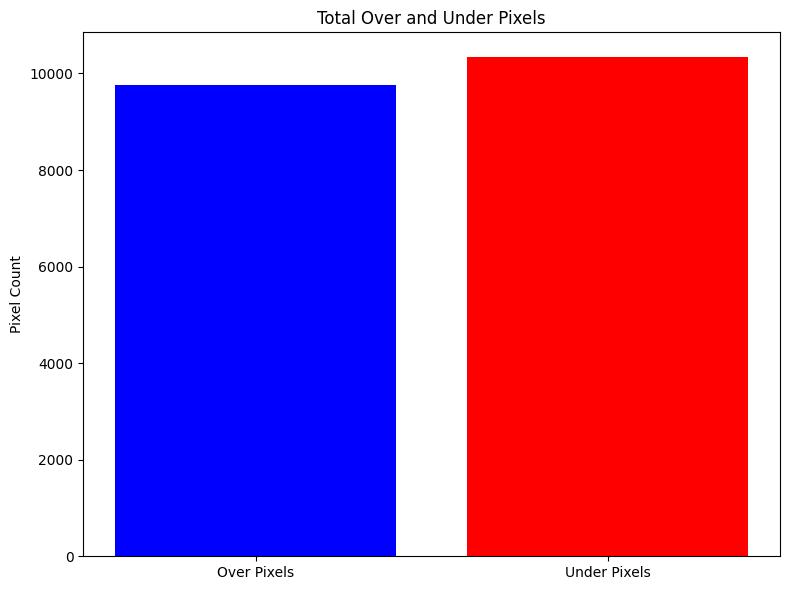

In [19]:
import matplotlib.pyplot as plt

# over_pixels, under_pixels의 합을 계산
total_over_pixels = sum(metrics['avg_over_pixels'] for metrics in image_metrics.values())
total_under_pixels = sum(metrics['avg_under_pixels'] for metrics in image_metrics.values())

# 시각화
labels = ['Over Pixels', 'Under Pixels']
values = [total_over_pixels, total_under_pixels]

print(f'total over pixels: {total_over_pixels}')
print(f'total under pixels: {total_under_pixels}')

# 막대 차트 그리기
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, values, color=['blue', 'red'])

# 제목 및 레이블
ax.set_title('Total Over and Under Pixels')
ax.set_ylabel('Pixel Count')

# 그래프 표시
plt.tight_layout()
plt.show()


## 각 클래스 별 over & under predict 비율에 따라 threshold 조정

In [20]:
def adjust_thresholds_dynamic(avg_metrics, initial_thresholds, base_rate=[0.05, 0.10, 0.15, 0.20], max_adjust=0.3, min_ratio=0.5, max_ratio=2.0):
    """
    Under/Over 비율 기반으로 threshold를 동적으로 조정 (비율에 따라 조정 폭이 변동)
    :param avg_metrics: 클래스별 평균 over/under 픽셀 수 딕셔너리
    :param initial_thresholds: 초기 threshold 값 딕셔너리
    :param base_rate: 비율이 1일 때의 기본 조정 폭 (예: [0.05, 0.10, 0.15, 0.2])
    :param max_adjust: 최대 조정 폭 제한 (예: 0.3)
    :param min_ratio: Under/Over 비율의 최소 허용치 (0.5 미만이면 threshold 증가)
    :param max_ratio: Under/Over 비율의 최대 허용치 (2.0 초과면 threshold 감소)
    :return: 4개의 조정된 threshold 리스트 (각각의 비율에 따라)
    """
    # 각 비율에 맞는 threshold들을 계산할 리스트
    adjusted_thresholds = {base_rate[0]: [], base_rate[1]: [], base_rate[2]: [], base_rate[3]: []}
    
    for class_name, metrics in avg_metrics.items():
        over_pixels = metrics["avg_over_pixels"]
        under_pixels = metrics["avg_under_pixels"]
        
        # 비율 계산 (0으로 나누는 상황 방지)
        if over_pixels > 0:
            ratio = under_pixels / over_pixels
        else:
            ratio = float('inf')  # Over-pixels가 0이면 비율이 무한대로 간주
        
        print(f"Class: {class_name}")
        print(f"  Over Pixels: {over_pixels}, Under Pixels: {under_pixels}, Ratio: {ratio:.2f}")
        
        # 현재 클래스의 threshold
        current_threshold = initial_thresholds[class_name]
        
        # 각 비율을 기준으로 threshold를 동적으로 조정하고, 그 결과를 4개의 리스트에 저장
        for rate in base_rate:
            if ratio < min_ratio:  # 비율이 너무 작을 경우 threshold 증가
                adjust_amount = min(rate, max_adjust)
                adjusted_threshold = current_threshold + adjust_amount
            elif min_ratio <= ratio < 1:  # 비율이 1보다 작은 경우
                adjust_amount = min(rate / ratio, max_adjust)
                adjusted_threshold = current_threshold + adjust_amount
            elif 1 <= ratio <= max_ratio:  # 비율이 1과 max_ratio 사이
                adjust_amount = min(rate * ratio, max_adjust)
                adjusted_threshold = current_threshold - adjust_amount
            else:  # 비율이 너무 클 경우 threshold 감소
                adjust_amount = min(rate, max_adjust)
                adjusted_threshold = current_threshold - adjust_amount

            # Threshold 값 제한
            adjusted_threshold = max(0.2, min(0.8, adjusted_threshold))
            
            # 해당 rate에 해당하는 threshold 리스트에 추가
            adjusted_thresholds[rate].append(adjusted_threshold)
            
            print(f"  Adjusted Threshold (base_rate={rate}): {adjusted_threshold:.2f} (Adjust Amount: {adjust_amount:.2f})")
    
    return adjusted_thresholds


In [24]:
# 초기 threshold 설정
initial_thresholds = {class_name: 0.5 for class_name in CLASSES}

# 평균 over/under 비율로 threshold 조정
new_thresholds = adjust_thresholds_dynamic(image_metrics, initial_thresholds)

Class: finger-1
  Over Pixels: 213.22151898734177, Under Pixels: 312.0189873417722, Ratio: 1.46
  Adjusted Threshold (base_rate=0.05): 0.43 (Adjust Amount: 0.07)
  Adjusted Threshold (base_rate=0.1): 0.35 (Adjust Amount: 0.15)
  Adjusted Threshold (base_rate=0.15): 0.28 (Adjust Amount: 0.22)
  Adjusted Threshold (base_rate=0.2): 0.21 (Adjust Amount: 0.29)
Class: finger-2
  Over Pixels: 228.1772151898734, Under Pixels: 358.40506329113924, Ratio: 1.57
  Adjusted Threshold (base_rate=0.05): 0.42 (Adjust Amount: 0.08)
  Adjusted Threshold (base_rate=0.1): 0.34 (Adjust Amount: 0.16)
  Adjusted Threshold (base_rate=0.15): 0.26 (Adjust Amount: 0.24)
  Adjusted Threshold (base_rate=0.2): 0.20 (Adjust Amount: 0.30)
Class: finger-3
  Over Pixels: 397.75949367088606, Under Pixels: 337.5886075949367, Ratio: 0.85
  Adjusted Threshold (base_rate=0.05): 0.56 (Adjust Amount: 0.06)
  Adjusted Threshold (base_rate=0.1): 0.62 (Adjust Amount: 0.12)
  Adjusted Threshold (base_rate=0.15): 0.68 (Adjust Amoun

In [25]:
for key, value in new_thresholds.items():
    print(f'{key}: {value}')

0.05: [0.42683220042150255, 0.42146344169532896, 0.5589118656142785, 0.4483538268506901, 0.4300880672058961, 0.4340144318375082, 0.44678898544605894, 0.5508524277141298, 0.42578861185775635, 0.446277113018477, 0.4492066664889884, 0.5709631191866753, 0.43637614404498415, 0.4473123051834114, 0.4408046469756077, 0.5762126005008568, 0.5505086894674995, 0.5649709930259829, 0.5553997378768021, 0.5562852479561651, 0.41154956110465346, 0.44148933324416506, 0.5529343487822758, 0.43473694615365605, 0.5560565445505992, 0.5570549501409517, 0.42083229221088975, 0.5721178187905761, 0.552604946190578]
0.1: [0.3536644008430051, 0.3429268833906579, 0.6178237312285569, 0.39670765370138017, 0.36017613441179225, 0.3680288636750164, 0.3935779708921179, 0.6017048554282597, 0.3515772237155127, 0.39255422603695406, 0.39841333297797676, 0.6419262383733506, 0.3727522880899683, 0.39462461036682284, 0.38160929395121534, 0.6524252010017135, 0.6010173789349991, 0.6299419860519657, 0.6107994757536042, 0.612570495912